# Literature

$[1]$ --- Implementable tensor methods in unconstrained convex optimization, https://alfresco.uclouvain.be/alfresco/service/guest/streamDownload/workspace/SpacesStore/aabc2323-0bc1-40d4-9653-1c29971e7bd8/coredp2018_05web.pdf?guest=true.

$[2]$ ---  Cubic regularization of Newton method and its global performance, http://lab7.ipu.ru/files/polyak/Nest_Pol-MathProg'06.pdf.

$[3]$ --- Acelerating the cubic regularization of Newton’s method on convex
problems, http://webdoc.sub.gwdg.de/ebook/serien/e/CORE/dp2005_68.pdf.

$[4]$ --- A.R. Conn, N.I. M. Gould, and Ph.L. Toint. Trust Region Methods. SIAM, Philadelphia, 2000.

$[5]$ --- Анализ быстрого градиентного метода Нестерова для задач машинного обучения с $L_1$-регуляризацией, http://www.machinelearning.ru/wiki/images/0/03/Rodomanov_FGM.pdf.

In [1]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize_scalar, minimize
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd.numpy import linalg
from numpy import linalg
import math
import autograd.scipy as scipy
from scipy import optimize
import copy

##### Generation matrix $A_k$ for function $f_k(x)$ in $[1]$.$[4.3]$ by Yu. Nesterov (2018).

In [2]:
def generateAUI(k, n):
    U = np.zeros((k, k))
    I = np.eye(n - k)
    for i in range(k):
        U[i][i] = 1
        if (i + 1 < k):
            U[i][i + 1] = -1
    Ak = np.block([[U, np.zeros((k, n - k))], [np.zeros((n - k, k)), I]])        
    return Ak    

##### $f_k$ in $[1]$.$[4.3]$, its minimum and gradient, hessian and third derivative using autograd and closed-form expressions.

In [3]:
from autograd import grad    
from autograd import jacobian

def f(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)

    # Universal bad function
    Axn = np.dot(Ak, x)
    sum_Axn = np.sum(np.power(np.abs(Axn), p + 1))/(p + 1)
    return sum_Axn - x[0]

def x_opt_f(*args):
    k, n, p = args
    x_opt = np.zeros(n)
    for i in range(1, k + 1):
        x_opt[i - 1] = k - i + 1
    return x_opt

def f_opt(*args):
    k, n, p = args
    return -k*p/(p + 1)

grad_f = grad(f)       # Obtain its gradient function      

hess_f = jacobian(grad_f) # Obtain its hessian function 

tensor3_f = jacobian(hess_f) # Obtain its third derivative function 

def grad_f_true(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = (np.abs(arg_eta)**(p - 1))*arg_eta
    grad_ans = np.dot(Ak.T, arg_eta_abs)
    grad_ans[0] -= 1
    return grad_ans

def hess_f_true(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = p*(np.abs(arg_eta)**(p - 1))
    return np.dot(arg_eta_abs * Ak.T, Ak)

def tensor3_f_true(x, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = p*(p - 1)*(np.abs(arg_eta)**(p - 3))*arg_eta
    return np.einsum("i,im,il,it->mlt", arg_eta_abs, Ak, Ak, Ak)

def dot_tensor3_vect_vect_f_true(x, h, *args):
    k, n, p = args
    Ak = generateAUI(k, n)
    arg_eta = np.dot(Ak, x)
    arg_eta_abs = p*(p - 1)*(np.abs(arg_eta)**(p - 3))*arg_eta
    return sum([arg_eta_abs[i]*((np.dot(Ak[i], h))**2)*Ak[i] for i in range(n)])

##### Upper bounds on $L_p(f_k)$ for $f_k$ in $[1]$.$[4.3]$.

In [4]:
def generateU(k):
    U = np.zeros((k, k))
    for i in range(k):
        U[i][i] = 1
        if (i + 1 < k):
            U[i][i + 1] = -1
    return U

def Ak_2_norm(k, n):
    Uk = generateU(k)
    Uk_singular = np.dot(Uk.T, Uk)
    E, V = linalg.eigh(Uk_singular) 
    lambda_max = max(E)
    Uk_2_norm = lambda_max**0.5
    if (n - k > 0):
        return max(1, Uk_2_norm)
    else:
        return Uk_2_norm
    
def Lp_2_norm_real(*args):
    k, n, p = args
    return math.factorial(p)*((Ak_2_norm(k, n))**(p + 1))

def Lp_2_norm_upper_bound_real(*args):
    k, n, p = args
    return math.factorial(p)*(2**(p + 1))

def Lp_2_norm_Nesterov(*args):
    k, n, p = args
    return math.factorial(p)*((Ak_2_norm(k, n))**p)

def Lp_2_norm_upper_bound_Nesterov(*args):
    k, n, p = args
    return math.factorial(p)*(2**p)

def Lp_2_norm_stupid(*args):
    k, n, p = args
    return math.factorial(p)*2

def L2_upper_bound(L3, x0, *args):
    return L3 * 2*linalg.norm(x0 - x_opt_f(*args))

#k = 3
#Uk = generateU(k)
#Uk_singular = np.dot(Uk.T, Uk)
#E,V = linalg.eigh(Uk_singular) 
#lambda_max = max(E)
#Ak_norm = Ak_2_norm(5, 6)

#print(Uk_singular)
#print(E)
#print(Ak_norm)
#p = 3
#k = 50
#n = 100
#print(L3_2_norm(k, n, p))

##### Calculation parameters $c, A \succeq 0, \gamma > 0$ for auxiliary minimization problem $[1]$.$[5.8]$ in terms of problem 
$$
\langle c, h \rangle + \frac{1}{2}\langle Ah, h \rangle + \frac{\gamma}{4}||h||_2^4 \rightarrow \min\limits_{h \in \mathbb{R}^n}
$$ 

In [5]:
def calc_cur_params(grad_f_cur, hessian_f_cur, tensor3_f_cur_vect, hk, tau, L):
    grad_d = np.dot(hk, hk.T)*hk
    c = (grad_f_cur - 1/tau*np.dot(hessian_f_cur, hk.T) + 0.5*tensor3_f_cur_vect 
                                                                        - tau*(tau + 1)/2*L*grad_d) + tau*tau*L/2*grad_d
    
    A = (tau + 1) / tau * hessian_f_cur
    
    gamma = tau*(tau + 1)/2*L
    return c, A, gamma

##### Objective function $f_{c, A, \gamma}(h) = \langle c, h \rangle + \frac{1}{2}\langle Ah, h \rangle + \frac{\gamma}{4}||h||_2^4$ for auxiliary minimization problem $[1]$.$[5.8]$ and its univariate dual function $g_{c, A, \gamma}(\tau) = \frac{1}{2}\tau^2 + \frac{1}{2}\Bigl\langle \bigl(\sqrt{2\gamma}\tau B + A\bigr)^{-1}c, c \Bigr\rangle$ with $B = I_{n \times n}$ for Euclid 2-norm.

In [6]:
def aux_problem_func(h, *args):
    c, A, gamma = args
    d = linalg.norm(h)
    d4 = d*d*d*d
    return np.dot(c, h) + 0.5 * np.dot(np.dot(A, h), h) + 0.25*gamma*d4 

def aux_problem_onedim_func(tau, *args):
    c, A, B, gamma = args
    sgam = math.sqrt(2*gamma)
    S = sgam*tau*B + A
    invS = linalg.inv(S)
    f = 0.5*tau*tau + 0.5 * np.dot(np.dot(invS, c), c)
    
    return f

##### Calculation minimum of $f_{c, A, \gamma}(h)$ using minimum of dual function $g_{c, A, \gamma}(\tau)$.

In [7]:
def calc_hopt(t, *args):
    c, A, B, gamma = args
    S = math.sqrt(2*gamma)*t*B + A
    invS = linalg.inv(S)
    h_opt = -np.dot(invS, c)
    return h_opt

##### Newton's method for finding minimum $g_{c, A, \gamma}(\tau)$ based on $[4]$, Chapter $7$.

The main idea is to find root $\lambda > 0$ of first-order optimality condition: $\sqrt{\lambda} = ||s(\lambda)||_2, s(\lambda) = -(A + \lambda I)^{-1}c_{\text{new}}, \lambda = \sqrt{2\gamma}\tau, c_{\text{new}} = \sqrt{\gamma}c$.

It is better to solve the secular equation:
$$
\phi(\lambda) = \frac{1}{||s(\lambda)||_{2}} - \frac{1}{\sqrt{\lambda}}.
$$
So 
$$
\phi^{'}(\lambda) = \frac{\bigl \langle s(\lambda), A(\lambda)^{-1}s(\lambda) \bigr \rangle}{||s(\lambda)||_2^3} + \frac{1}{2\lambda^{\frac{3}{2}}} \geq 0, A(\lambda) = A + \lambda I;
$$
$$
\phi^{''}(\lambda) = \frac{3\Bigl(\bigl \langle s(\lambda), \nabla_{\lambda}s(\lambda) \bigr \rangle^2 - ||s(\lambda)||_2^2||\nabla_{\lambda}s(\lambda)||_2^2\Bigr)}{||s(\lambda)||_2^5} - \frac{3}{4\lambda^{\frac{5}{2}}} < 0
$$ by Cauchy-Schwartz inequality.

Newton's method for finding a root of the scalar equation $\phi(\lambda) = 0$ replaces  the estimate $\lambda_k > 0$ with the improved estimate $\lambda_{k + 1}$ for which
$$
\lambda_{k + 1} = \lambda_k - \frac{\phi(\lambda_k)}{\phi^{'}(\lambda_k)}.
$$
Using Cholesky factors $A(\lambda) = L(\lambda)L^T(\lambda)$ we can write:
$$
\bigl \langle s, A(\lambda)^{-1}s \bigr \rangle = \bigl \langle s, L^{-T}L^{-1}s \bigr \rangle = \bigl \langle L^{-1}s, L^{-1}s \bigr \rangle = ||w(\lambda)||_2^2
$$
with $w(\lambda) = L^{-1}(\lambda)s(\lambda)$.
The complete Newton algorithm is:
$$
\lambda_{k + 1} = \lambda_k \cdot \Bigl(1 - 2||s(\lambda_k)||_2^2\frac{\sqrt{\lambda_k} - ||s(\lambda_k)||_2}{||s(\lambda_k)||_2^3 + 2||w(\lambda_k)||_2^2\lambda_k^{\frac{3}{2}}}\Bigr) 
$$ while $\lambda_{k + 1} > 0$.

In [8]:
def Newton_step_tensor3(AuxMaxIter, *args):
    c, H, gamma, eps = args
    c_new = c*(gamma**0.5)
    lambda_ans = eps
    k = 0
    while (k < AuxMaxIter):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        try:
            L = linalg.cholesky(H_lambda)
        except np.linalg.LinAlgError:
            break
        s = linalg.solve(H_lambda, -c_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            2*(lambda_ans**0.5 - linalg.norm(s))*(linalg.norm(s)**2)/
                                  (linalg.norm(s)**3 + 2*(linalg.norm(w)**2)*(lambda_ans**(1.5))))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    #tau_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + lambda_ans*np.identity(H.shape[0])), c)
    #h_opt2 = -np.dot(linalg.pinv(H), c)
    #val_1 = np.dot(c, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + gamma/4*(linalg.norm(h_opt1)**4)
    #val_2 = np.dot(c, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + gamma/4*(linalg.norm(h_opt2)**4)
    #if (val_1 < val_2):
     #   h_opt = h_opt1
    #else:
      #  h_opt = h_opt2
    #return h_opt
    return h_opt1

##### Iteration of process $[1].[5.8]$ to solve auxiliary minimization problem $[1]$.$[5.4]$.

In [9]:
def T3M(x, aux_prob_method, grad_f_cur, hess_f_cur, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, eps, *args):
    
    size = x.shape[0]
    hk = np.zeros(size)
    B = np.eye(size)
 
    if aux_prob_method == 1:
        xb = L*1e10
        t0 = 0+eps
    
    for aux_k in range(1, TensorMaxIter + 1):
        tensor3_f_cur_vect = tensor3_f_direct(x, hk, *args)
        c, A, gamma = calc_cur_params(grad_f_cur, hess_f_cur, tensor3_f_cur_vect, hk, tau, L)
            
        if aux_prob_method == 1:
            allargs = (c, A, B, gamma)

            res = optimize.minimize_scalar(aux_problem_onedim_func, args = allargs, method = 'bounded', bounds=(t0, xb), 
                                                            options={'maxiter': AuxMaxIter, 'disp': False})
            
            tau_opt = res.x
            
            h_opt = calc_hopt(tau_opt, *(c, A, B, gamma))
                
        elif aux_prob_method == 2:
            allargs = (c, A, gamma)
        
            res = optimize.minimize(aux_problem_func, args = allargs, tol = eps, x0 = hk, method = 'Powell', 
                                                                        options={'maxiter': AuxMaxIter, 'disp': False})                
            h_opt = res.x
                
        elif aux_prob_method == 3:
            h_opt = Newton_step_tensor3(AuxMaxIter, *(c, A, gamma, eps))
        hk = h_opt
    return (hk + x)      

##### Tensor method $[1]$.$[2.16]$ by Yu. Nesterov (2018), $p = 3$
Parameters:  
$NumIter$ --- max number of steps in tensor method.

$TensorMaxIter$ --- max number of iterations in auxiliary problem solution method $[1]$.$[5.8]$.

$AuxMaxIter$ --- max number of iterations to perform step $[1]$.$[5.8]$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.

$\langle \nabla^3 f(x) h, h \rangle$ --- objective third directional derivative of $f$ at $x$ along direction $h$ oracle .

$\tau > 1$ - parameter in $[1]$.$[5.5]$.

$L_3(f)$ - uniform bound for the Lipschitz constant of third derivative.

$\varepsilon$ - parameter to perform step $[1]$.$[5.8]$, meaning depends of $aux\_prob\_method$.

$aux\_prob\_method$ --- how to solve auxiliary problem (5.4): $1$ --- by means of minimization $g_{c, A, \gamma}(\tau)$ using $scipy.optimize$, $2$ --- by means of minimization $f_{c, A, \gamma}(h)$ using $scipy.optimize$, $3$ --- by means of minimization $g_{c, A, \gamma}(\tau)$ using Newton's method.

$args$ - arguments for parametrization of $f$.

In [10]:
def Tensor3_iter(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                                             aux_prob_method, *args):
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)

    for k in range(NumIter):
        f_xk = f(xk, *args)
        grad_f_xk = grad_f(xk, *args)
        hessian_f_xk = hess_f(xk, *args)
        farr[k] = f_xk
        #fgradarr[k] = linalg.norm(grad_f_xk)
        xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter,
                                                             tau, L, eps, *args) 
    
    f_xk = f(xk, *args)
    #grad_f_xk = grad_f(xk, *args)
    farr[NumIter] = f_xk
    #fgradarr[NumIter] = linalg.norm(grad_f_xk)
    
    return xk, f_xk, farr#, fgradarr
    
    

##### Prox function

In [11]:
def proxd(x, p):
    return 1. / p * (linalg.norm(x)**p) 

##### Accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018), $p = 3$

This method has additional parameter $version$ = 1 if we use formula for $A_k$ (as is $[1]$.$[3.11]$):
$$
A_k = \Bigl[\frac{(p - 1)(M^2 - L_p^2)}{4(p + 1)M^2}\Bigr]\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}
$$
and $version$ = 2 if we use formula for $A_k$:
$$
A_k = \Bigl[\frac{(p + 1)(M^2 - L_p^2)}{4(p - 1)M^2}\Bigr]\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}.
$$
Both versions use formula $[1]$.$[5.5]$:
$$
M = \tau^2 L_3.
$$

In [12]:
def TensorAcc3_iter(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                               aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    farr[0] = f_xk
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, 
                                                                                                         eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 3
    C = p / 2 * math.sqrt((p+1)/(p-1)*(M*M - L*L))
    
    min_psik = copy.deepcopy(x0)
    size = x0.shape[0]
    sk = np.zeros(size)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L*L) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L*L) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T3M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, 
                                                                                     tau, L, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, f_xk, farr#, fgradarr, k
    

##### Variant of fast gradient method based on Algorithm 1 in $[5]$.

Parameters:  
$NumIter$ --- max number of steps in FGM.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$L_1(f)$ - uniform bound for the Lipschitz constant of first derivative.

$args$ - arguments for parametrization of $f$.

In [13]:
def FGM_iter(NumIter, x0, f, gradf, L1, *args):
    k = 0
    v_k = copy.deepcopy(x0)
    x_k = copy.deepcopy(x0)
    A_k = 0
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    farr[0] = f(x_k, *args)
    #fgradarr[0] = linalg.norm(gradf(x_k, *args))
    while (k < NumIter):
        a_k = (1 + (1 + 2 * L1 * A_k)**0.5) / L 
        y_k = (A_k*x_k + a_k*v_k)/(A_k + a_k)
        x_k = y_k - 1/L1*gradf(y_k, *args)
        gradf_xk = gradf(x_k, *args)
        v_k = v_k - a_k * gradf_xk
        A_k = A_k + a_k
        k += 1
        f_xk = f(x_k, *args)
        farr[k] = f_xk
        #fgradarr[k] = linalg.norm(gradf_xk)
    return x_k, farr#, k, fgradarr

##### Newton's method for finding minimum $\Omega_{g, H, M}(h) = \langle g, h \rangle + \frac{1}{2}\langle Hh, h \rangle + \frac{M}{6}||h||_2^3$ in $[3]$.$[5.1]$ based on one-dimensional equation $[3]$.$[5.4]$ and methods in $[4]$, Chapter $7$. Note that we assume $M > 0, H \succeq 0$.

The main idea is to find root $ \lambda_{\text{root}} > 0$ of first-order optimality condition: $\lambda = ||s(\lambda)||_2, s(\lambda) = -(H + \lambda I)^{-1}g_{\text{new}}, \lambda = \frac{M}{2}||h_{\text{opt}}||_2, g_{\text{new}} = \frac{M}{2}g, h = -(H + \lambda_{\text{root}} I)^{-1}g$.

It is better to solve the secular equation:
$$
\phi(\lambda) = \frac{1}{||s(\lambda)||_{2}} - \frac{1}{\lambda}.
$$
So 
$$
\phi^{'}(\lambda) = \frac{\bigl \langle s(\lambda), A(\lambda)^{-1}s(\lambda) \bigr \rangle}{||s(\lambda)||_2^3} + \frac{1}{\lambda^2} \geq 0, A(\lambda) = A + \lambda I;
$$
$$
\phi^{''}(\lambda) = \frac{3\Bigl(\bigl \langle s(\lambda), \nabla_{\lambda}s(\lambda) \bigr \rangle^2 - ||s(\lambda)||_2^2||\nabla_{\lambda}s(\lambda)||_2^2\Bigr)}{||s(\lambda)||_2^5} - \frac{2}{\lambda^3} < 0
$$ by Cauchy-Schwartz inequality.

Newton's method for finding a root of the scalar equation $\phi(\lambda) = 0$ replaces  the estimate $\lambda_k > 0$ with the improved estimate $\lambda_{k + 1}$ for which
$$
\lambda_{k + 1} = \lambda_k - \frac{\phi(\lambda_k)}{\phi^{'}(\lambda_k)}.
$$
Using Cholesky factors $A(\lambda) = L(\lambda)L^T(\lambda)$ we can write:
$$
\bigl \langle s, A(\lambda)^{-1}s \bigr \rangle = \bigl \langle s, L^{-T}L^{-1}s \bigr \rangle = \bigl \langle L^{-1}s, L^{-1}s \bigr \rangle = ||w(\lambda)||_2^2
$$
with $w(\lambda) = L^{-1}(\lambda)s(\lambda)$.
The complete Newton algorithm is:
$$
\lambda_{k + 1} = \lambda_k \cdot \Bigl(1 - ||s(\lambda_k)||_2^2\frac{\lambda_k - ||s(\lambda_k)||_2}{||s(\lambda_k)||_2^3 + ||w(\lambda_k)||_2^2\lambda_k^{2}}\Bigr) 
$$ while $\lambda_{k + 1} > 0$.

In [14]:
def Newton_cubic_step(x_k, NumIterStep, *args):
    g, H, M, eps = args
    g_new = g*M/2
    lambda_ans = eps
    k = 0
    while (k < NumIterStep):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        try:
            L = linalg.cholesky(H_lambda)
        except np.linalg.LinAlgError:
            break
        s = linalg.solve(H_lambda, -g_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            (lambda_ans - linalg.norm(s))*(linalg.norm(s)**2)/(linalg.norm(s)**3 + (linalg.norm(w)**2)*(lambda_ans**2)))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    #r_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + lambda_ans*np.identity(H.shape[0])), g)
    h_opt = h_opt1
    #h_opt2 = -np.dot(linalg.pinv(H), g)
    #val_1 = np.dot(g, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + M/6*(linalg.norm(h_opt1)**3)
    #val_2 = np.dot(g, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + M/6*(linalg.norm(h_opt2)**3)
    #if (val_1 < val_2):
    #    h_opt = h_opt1
    #else:
    #    h_opt = h_opt2
    return x_k + h_opt

##### Cubic regularization of Newton method using procedure $[2]$.$[3.3]$

Parameters:  
$NumIter$ --- max number of steps in method.

$NumIterStep$ --- max number of Newton iterations to perform $Newton\_cubic\_step$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.

$adapt$ --- $adapt = 0$ if we use nonadaptive version of algorithm $[2]$.$[3.3]$ with $M_k = L_2(f)$ and $adapt = 1$ if we use adaptive version of algorithm $[2]$.$[3.3]$ with procedure $[2]$.$[5.7]$.


$L_2(f)$ - uniform bound for the Lipschitz constant of hessian for $adapt = 0$ and $L_0$ in $[2]$.$[3.3]$ and procedure $[2]$.$[5.7]$ for $adapt = 1$.

$\varepsilon$ - initial point to perform $Newton\_cubic\_step$.



$args$ - arguments for parametrization of $f$.

In [15]:
def Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L, eps, adapt, *args):
    k = 0
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    if (adapt == 1):
        M_k = L
    while (k < NumIter):
        #print("iter = {0}".format(k))
        f_current = f(x_k, *args)
        grad_f_current = grad_f(x_k, *args)
        hessian_f_current = hessian_f(x_k, *args)
        farr[k] = f_current
        #fgradarr[k] = linalg.norm(grad_f_current)
        if (adapt == 1):
            while(1):
                T_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, M_k, eps))
                if (f(T_k, *args) > f_current):
                    M_k = 2*M_k
                    #print("M_k = {0}".format(M_k))
                else:
                    break
            x_k = T_k
            M_k = max(1/2*M_k, L0)
        elif (adapt == 0):
            x_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, L, eps))
        k += 1
    f_current = f(x_k, *args)
    #grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    #fgradarr[k] = linalg.norm(grad_f_current)
    return x_k, farr#, fgradarr

##### Accelerated cubic regularization of Newton'd method using procedure $[3]$.$[4.8]$

Parameters:  
$NumIter$ --- max number of steps in tensor method.

$NumIterStep$ --- max number of Newton iterations to perform $Newton\_cubic\_step$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.


$L_2(f)$ - uniform bound for the Lipschitz constant of hessian.

$\varepsilon$ - initial point to perform $Newton\_cubic\_step$.



$args$ - arguments for parametrization of $f$.

In [16]:
def calc_v_k(x0, N, s_k):
    eps = 1e-10
    norm = linalg.norm(s_k)
    if norm < eps:
        return x0
    else:
        return x0 - (2/N)**0.5*s_k/norm

def fast_Newton_cubic_solver_iter(x0, NumIter, NumIterStep, f, grad_f, hessian_f, L2, eps, *args):
    N = 12*L2
    M = 2*L2
    k = 0
    s_k = np.zeros(x0.shape[0])
    x_k = copy.deepcopy(x0)
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    grad_f_current = grad_f(x_k, *args)
    hessian_f_current = hessian_f(x_k, *args)
    farr[0] = f(x_k, *args)
    #fgradarr[0] = linalg.norm(grad_f_current)
    x_k = Newton_cubic_step(x_k, NumIterStep, *(grad_f_current, hessian_f_current, L2, eps))
    k += 1
    f_current = f(x_k, *args)
    #grad_f_current = grad_f(x_k, *args)
    farr[k] = f_current
    #fgradarr[k] = linalg.norm(grad_f_current)
    while (k < NumIter):
        v_k = calc_v_k(x0, N, s_k)
        y_k = k/(k + 3)*x_k + 3/(k + 3)*v_k
        grad_f_current = grad_f(y_k, *args)
        hessian_f_current = hessian_f(y_k, *args)
        x_k = Newton_cubic_step(y_k, NumIterStep, *(grad_f_current, hessian_f_current, M, eps))
        gradf_xk = grad_f(x_k, *args)
        s_k += (k + 1)*(k + 2)/2*gradf_xk
        k += 1
        farr[k] = f(x_k, *args)
        #fgradarr[k] = linalg.norm(gradf_xk)
    return x_k, farr#, fgradarr

# Our problem and it's parametres, $n = 10$

In [17]:
n = 10
k = n // 2
NumIter = 50
TensorNumIter = 40
eps = 1e-7
tau = 1 + eps

x0 = np.zeros(n)
AuxMaxIter = 100
L0 = eps

p = 3
args = (k, n, p)

# Experiments using closed-form expressions for tensors of $f_k$

In this section we use $L_3 = 2^p p!$ according to page $16$ in $[1]$.

In [19]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
xans1, fans1, farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
                    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('1xans ', xans1)
print('1fans, it1 ', fans1, NumIter)

aux_prob_method = 2
xans2, fans2, farr2 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
                    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('2xans ', xans2)
print('2fans, it2 ', fans2, NumIter)

aux_prob_method = 3
xans3, fans3, farr3 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
                    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('3xans ', xans3)
print('3fans, it3 ', fans3, NumIter)

version = 1

aux_prob_method = 1
xans4, fans4, farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', xans4)
print('4fans, it4 ', fans4, NumIter)

aux_prob_method = 2
xans5, fans5, farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('5xans ', xans5)
print('5fans, it5 ', fans5, NumIter)

aux_prob_method = 3
xans6, fans6, farr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('6xans ', xans6)
print('6fans, it6 ', fans6, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
xans_newton_cubic_iter_nd, farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2, eps, adapt, *args)
print('xans_newton_nonadapt ', xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', farr_newton_cubic_iter_nd[NumIter], NumIter)



1xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
1fans, it1  -3.75 50
2xans  [  5.00000000e+00   4.00000000e+00   3.00000000e+00   2.00000000e+00
   1.00000000e+00  -1.65222119e-09  -1.66092181e-09  -1.67845526e-09
  -1.69712304e-09  -1.71191302e-09]
2fans, it2  -3.75 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


3xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
3fans, it3  -3.75 50
4xans  [ 2.40302247  1.5649784   0.89285048  0.39307106  0.07917137  0.          0.
  0.          0.          0.        ]
4fans, it4  -2.21065456121 50
5xans  [  2.40303027e+00   1.56498556e+00   8.92856366e-01   3.93075098e-01
   7.91730651e-02  -1.60628985e-08  -1.69230457e-08  -1.50327640e-08
  -1.50307634e-08  -1.06504566e-08]
5fans, it5  -2.21066129352 50
6xans  [ 2.40303028  1.56498556  0.89285637  0.3930751   0.07917307  0.          0.
  0.          0.          0.        ]
6fans, it6  -2.21066129799 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


xans_newton_adapt  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
xans_newton_adapt, it  -3.75 50
xans_newton_nonadapt  [  1.84676652e+00   9.86093977e-01   3.16611569e-01   1.00307421e-02
   1.24128180e-07   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
xans_newton_nonadapt, it  -1.65715527485 50


##### Plot scatter graphs

/usr/local/lib/python3.6/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


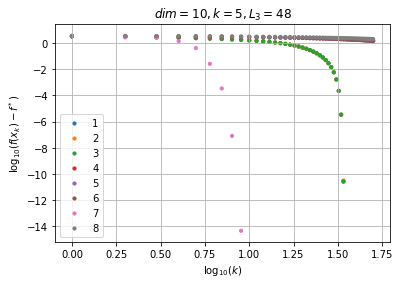

In [20]:
fig = plt.figure()
s = [10 for n in range(len(farr1) - 1)]

plt.xlabel(r'$\log_{10}(k)$') 
plt.ylabel(r'$\log_{10}(f(x_k) - f^*)$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

log_i = [np.log10(i) for i in range(1, NumIter + 1)]

plt.scatter(log_i, [np.log10(farr1[i] - fopt) for i in range(1, NumIter + 1)], label = '1', s = s)
plt.scatter(log_i, [np.log10(farr2[i] - fopt) for i in range(1, NumIter + 1)], label = '2', s = s)
plt.scatter(log_i, [np.log10(farr3[i] - fopt) for i in range(1, NumIter + 1)], label = '3', s = s)
plt.scatter(log_i, [np.log10(farr4[i] - fopt) for i in range(1, NumIter + 1)], label = '4', s = s)
plt.scatter(log_i, [np.log10(farr5[i] - fopt) for i in range(1, NumIter + 1)], label = '5', s = s)
plt.scatter(log_i, [np.log10(farr6[i] - fopt) for i in range(1, NumIter + 1)], label = '6', s = s)
#plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_ad[i] - fopt) for i in range(1, NumIter + 1)], label = '7', s = s)
plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_nd[i] - fopt) for i in range(1, NumIter + 1)], label = '8', s = s)

plt.legend()
plt.grid(True) 
fig.savefig('Scatter_Tensor3_f_L3={0}_iter.pdf'.format(L3))
plt.show()

##### Plot semilogy graphs

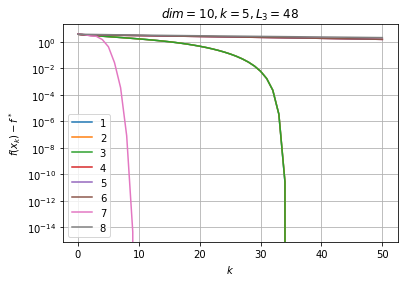

In [21]:
fig = plt.figure()

plt.xlabel(r'$k$') 
plt.ylabel(r'$f(x_k) - f^*$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, farr1 - fopt, label = '1')
plt.semilogy(arr_i, farr2 - fopt, label = '2')
plt.semilogy(arr_i, farr3 - fopt, label = '3')
plt.semilogy(arr_i, farr4 - fopt, label = '4')
plt.semilogy(arr_i, farr5 - fopt, label = '5')
plt.semilogy(arr_i, farr6 - fopt, label = '6')
#plt.plot([i for i in range(NumIter + 1)], farr_fgm, label = 'FGM')
plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = '7')
plt.semilogy(arr_i, farr_newton_cubic_iter_nd - fopt, label = '8')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_L3={0}_iter.pdf'.format(L3))
plt.show()

##### Comparing versions of Accelerated tensor method

In [22]:
version = 1

aux_prob_method = 1
comp_xans1, comp_fans1, comp_farr1 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('1xans ', comp_xans1)
print('1fans, it1 ', comp_fans1, NumIter)

aux_prob_method = 2
comp_xans2, comp_fans2, comp_farr2 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('2xans ', comp_xans2)
print('2fans, it2 ', comp_fans2, NumIter)

aux_prob_method = 3
comp_xans3, comp_fans3, comp_farr3 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('3xans ', comp_xans3)
print('3fans, it3 ', comp_fans3, NumIter)

version = 2

aux_prob_method = 1
comp_xans4, comp_fans4, comp_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', comp_xans4)
print('4fans, it4 ', comp_fans4, NumIter)

aux_prob_method = 2
comp_xans5, comp_fans5, comp_farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('5xans ', comp_xans5)
print('5fans, it5 ', comp_fans5, NumIter)

aux_prob_method = 3
comp_xans6, comp_fans6, comp_farr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('6xans ', comp_xans6)
print('6fans, it6 ', comp_fans6, NumIter)

1xans  [ 2.40302247  1.5649784   0.89285048  0.39307106  0.07917137  0.          0.
  0.          0.          0.        ]
1fans, it1  -2.21065456121 50
2xans  [  2.40303027e+00   1.56498556e+00   8.92856366e-01   3.93075098e-01
   7.91730651e-02  -1.60628985e-08  -1.69230457e-08  -1.50327640e-08
  -1.50307634e-08  -1.06504566e-08]
2fans, it2  -2.21066129352 50
3xans  [ 2.40303028  1.56498556  0.89285637  0.3930751   0.07917307  0.          0.
  0.          0.          0.        ]
3fans, it3  -2.21066129799 50
4xans  [ 2.41327635  1.57451485  0.90095889  0.39903843  0.08218026  0.          0.
  0.          0.          0.        ]
4fans, it4  -2.21968726498 50
5xans  [  2.41328415e+00   1.57452199e+00   9.00964771e-01   3.99042464e-01
   8.21819711e-02  -1.62341345e-08  -1.10442458e-08  -1.14485972e-08
  -1.13641948e-08  -1.54488216e-08]
5fans, it5  -2.21969398237 50
6xans  [ 2.41328415  1.574522    0.90096478  0.39904248  0.08218198  0.          0.
  0.          0.          0.        ]


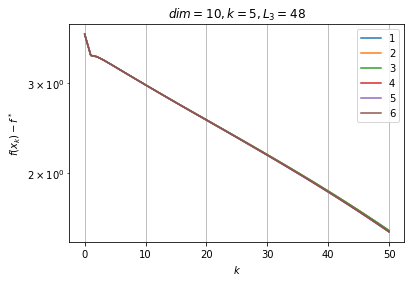

In [23]:
fig = plt.figure()

plt.xlabel(r'$k$') 
plt.ylabel(r'$f(x_k) - f^*$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, comp_farr1 - fopt, label = '1')
plt.semilogy(arr_i, comp_farr2 - fopt, label = '2')
plt.semilogy(arr_i, comp_farr3 - fopt, label = '3')
plt.semilogy(arr_i, comp_farr4 - fopt, label = '4')
plt.semilogy(arr_i, comp_farr5 - fopt, label = '5')
plt.semilogy(arr_i, comp_farr6 - fopt, label = '6')

plt.legend()
plt.grid(True) 
fig.savefig('Comp_acc_Tensor3_f_L3={0}_iter.pdf'.format(L3))
plt.show()

# In this section we use $L_3 = 2^{p + 1} p!$ 

In [24]:
L3_big = Lp_2_norm_upper_bound_real(*args)
L2_big = L2_upper_bound(L3_big, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
bigL_xans1, bigL_fans1, bigL_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
                x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_big, eps, aux_prob_method, *args)
print('1xans ', bigL_xans1)
print('1fans, it1 ', bigL_fans1, NumIter)

version = 1

aux_prob_method = 1
bigL_xans4, bigL_fans4, bigL_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_big, eps, aux_prob_method, version, *args)
print('4xans ', bigL_xans4)
print('4fans, it4 ', bigL_fans4, NumIter)

aux_prob_method = 2
bigL_xans5, bigL_fans5, bigL_farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_big, eps, aux_prob_method, version, *args)
print('5xans ', bigL_xans5)
print('5fans, it5 ', bigL_fans5, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
bigL_xans_newton_cubic_iter_ad, bigL_farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
bigL_xans_newton_cubic_iter_nd, bigL_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2_big, eps, adapt, *args)
print('xans_newton_nonadapt ', bigL_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', bigL_farr_newton_cubic_iter_nd[NumIter], NumIter)

1xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
1fans, it1  -3.75 50
4xans  [ 2.03756308  1.22369885  0.601521    0.18174778  0.00705142  0.          0.
  0.          0.          0.        ]
4fans, it4  -1.88242000165 50
5xans  [  2.03756255e+00   1.22369842e+00   6.01520755e-01   1.81747764e-01
   7.05142618e-03  -5.05290977e-09  -4.31259955e-09  -4.30275463e-09
  -4.30360069e-09  -5.71332958e-09]
5fans, it5  -1.88241958717 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


xans_newton_adapt  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
xans_newton_adapt, it  -3.75 50
xans_newton_nonadapt  [  1.44493785e+00   6.23011463e-01   7.58280999e-02   6.56252423e-05
   1.53349800e-14   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
xans_newton_nonadapt, it  -1.30842174545 50


##### Plot semilogy graphs

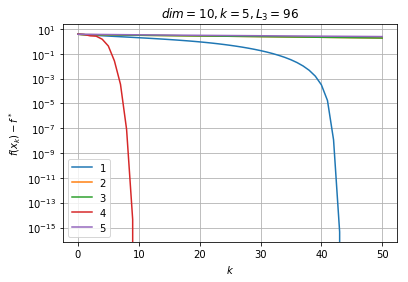

In [25]:
fig = plt.figure()

plt.xlabel(r'$k$') 
plt.ylabel(r'$f(x_k) - f^*$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3_big)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, bigL_farr1 - fopt, label = '1')
plt.semilogy(arr_i, bigL_farr4 - fopt, label = '2')
plt.semilogy(arr_i, bigL_farr5 - fopt, label = '3')
plt.semilogy(arr_i, bigL_farr_newton_cubic_iter_ad - fopt, label = '4')
plt.semilogy(arr_i, bigL_farr_newton_cubic_iter_nd - fopt, label = '5')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_L3={0}_iter.pdf'.format(L3_big))
plt.show()

# In this section we use smaller $L_3 = 2 \cdot p!$ to compare with previous values

In [27]:
L3_small = Lp_2_norm_stupid(*args)
L2_small = L2_upper_bound(L3_small, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
smallL_xans1, smallL_fans1, smallL_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
            x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_small, eps, aux_prob_method, *args)
print('1xans ', smallL_xans1)
print('1fans, it1 ', smallL_fans1, NumIter)

version = 1

aux_prob_method = 1
smallL_xans4, smallL_fans4, smallL_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_small, eps, aux_prob_method, version, *args)
print('4xans ', smallL_xans4)
print('4fans, it4 ', smallL_fans4, NumIter)

aux_prob_method = 2
smallL_xans5, smallL_fans5, smallL_farr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
    x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3_small, eps, aux_prob_method, version, *args)
print('5xans ', smallL_xans5)
print('5fans, it5 ', smallL_fans5, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
smallL_xans_newton_cubic_iter_nd, smallL_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2_small, eps, adapt, *args)
print('xans_newton_nonadapt ', smallL_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', smallL_farr_newton_cubic_iter_nd[NumIter], NumIter)

1xans  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
1fans, it1  -3.75 50
4xans  [ 3.31330924  2.43136071  1.66730641  1.01833369  0.4737165   0.          0.
  0.          0.          0.        ]
4fans, it4  -2.99792480666 50
5xans  [  3.31329938e+00   2.43135140e+00   1.66729825e+00   1.01832738e+00
   4.73712904e-01  -2.40581555e-09  -2.82647759e-09  -4.14394630e-09
   2.89613025e-09  -3.51974505e-09]
5fans, it5  -2.99791716228 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


xans_newton_adapt  [ 5.  4.  3.  2.  1.  0.  0.  0.  0.  0.]
xans_newton_adapt, it  -3.75 50
xans_newton_nonadapt  [ 2.94368885  2.03461651  1.23569816  0.57595786  0.10787004  0.          0.
  0.          0.          0.        ]
xans_newton_nonadapt, it  -2.61170416694 50


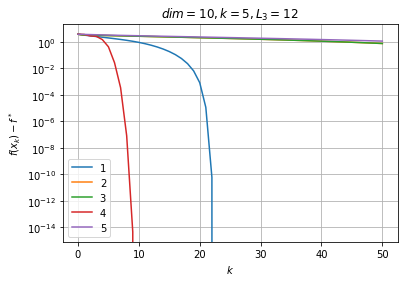

In [28]:
fig = plt.figure()

plt.xlabel(r'$k$') 
plt.ylabel(r'$f(x_k) - f^*$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3_small)) 

arr_i = [i for i in range(NumIter + 1)]

plt.semilogy(arr_i, smallL_farr1 - fopt, label = '1')
plt.semilogy(arr_i, smallL_farr4 - fopt, label = '2')
plt.semilogy(arr_i, smallL_farr5 - fopt, label = '3')
plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = '4')
plt.semilogy(arr_i, smallL_farr_newton_cubic_iter_nd - fopt, label = '5')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_L3={0}_iter.pdf'.format(L3_small))
plt.show()

# Next problem and it's parametres, $n = 100$

In [29]:
n = 100
k = n // 2
NumIter = 50
TensorNumIter = 40
eps = 1e-7
tau = 1 + eps

x0 = np.zeros(n)
AuxMaxIter = 100
L0 = eps

p = 3
args = (k, n, p)

# In this and next section we use $L_3 = 2^p p!$ according to page $16$ in $[1]$.

In [30]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
nbig_xans1, nbig_fans1, nbig_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('1xans ', nbig_xans1)
print('1fans, it1 ', nbig_fans1, NumIter)

#aux_prob_method = 2
#xans2, fans2, farr2, fgradarr2 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
               #                 x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('2xans ', xans2)
#print('2fans, it2 ', fans2, NumIter)

#aux_prob_method = 3
#xans3, fans3, farr3, fgradarr3 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('3xans ', xans3)
#print('3fans, it3 ', fans3, NumIter)
version = 1

aux_prob_method = 1
nbig_xans4, nbig_fans4, nbig_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', nbig_xans4)
print('4fans, it4 ', nbig_fans4, NumIter)

#aux_prob_method = 2
#xans5, fans5, farr5, fgradarr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('5xans ', xans5)
#print('5fans, it5 ', fans5, NumIter)

#aux_prob_method = 3
#xans6, fans6, farr6, fgradarr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('6xans ', xans6)
#print('6fans, it6 ', fans6, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f_true, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
nbig_xans_newton_cubic_iter_nd, nbig_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2_small, eps, adapt, *args)
print('xans_newton_nonadapt ', nbig_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', nbig_farr_newton_cubic_iter_nd[NumIter], NumIter)

1xans  [  6.79556254e+000   5.83628700e+000   4.92124429e+000   4.05450568e+000
   3.24089118e+000   2.48625850e+000   1.79798405e+000   1.18584619e+000
   6.63909051e-001   2.55746290e-001   2.21101587e-002   8.93152703e-006
   2.29491238e-016   1.05562269e-049   6.28893859e-155   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.000

##### Plot scatter graphs

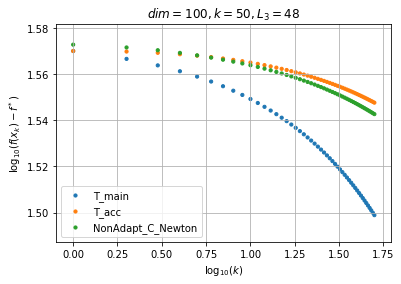

In [32]:
fig = plt.figure()
s = [10 for n in range(len(nbig_farr1) - 1)]

plt.xlabel(r'$\log_{10}(k)$') 
plt.ylabel(r'$\log_{10}(f(x_k) - f^*)$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

log_i = [np.log10(i) for i in range(1, NumIter + 1)]

plt.scatter(log_i, [np.log10(nbig_farr1[i] - fopt) for i in range(1, NumIter + 1)], label = 'T_main', s = s)
plt.scatter(log_i, [np.log10(nbig_farr4[i] - fopt) for i in range(1, NumIter + 1)], label = 'T_acc', s = s)
#plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_ad[i] - fopt) for i in range(1, NumIter + 1)], 
#                                                                        label = 'Adapt_C_Newton', s = s)
plt.scatter(log_i, [np.log10(nbig_farr_newton_cubic_iter_nd[i] - fopt) for i in range(1, NumIter + 1)], 
                                                                        label = 'NonAdapt_C_Newton', s = s)

plt.legend()
plt.grid(True) 
fig.savefig('Scatter_Tensor3_f_n={0}_iter.pdf'.format(n))
plt.show()

##### Plot semilogy graphs

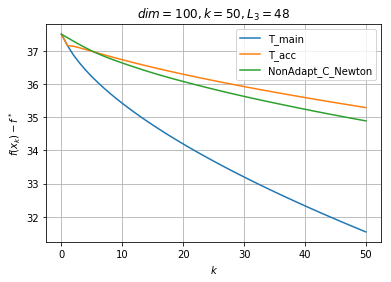

In [35]:
fig = plt.figure()

plt.xlabel(r'$k$') 
plt.ylabel(r'$f(x_k) - f^*$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.plot(arr_i, nbig_farr1 - fopt, label = 'T_main')
plt.plot(arr_i, nbig_farr4 - fopt, label = 'T_acc')
#plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = '4')
plt.plot(arr_i, nbig_farr_newton_cubic_iter_nd - fopt, label = 'NonAdapt_C_Newton')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_n={0}_iter.pdf'.format(n))
plt.show()

# Last problem for $f_k$ and it's parametres, $n = 1000$

In [38]:
n = 1000
k = n // 2
NumIter = 50
TensorNumIter = 40
eps = 1e-7
tau = 1 + eps

x0 = np.zeros(n)
AuxMaxIter = 100
L0 = eps

p = 3
args = (k, n, p)

In [40]:
L3 = Lp_2_norm_upper_bound_Nesterov(*args)
L2 = L2_upper_bound(L3, x0, *args)
fopt = f_opt(*args)

aux_prob_method = 1
nbiggest_xans1, nbiggest_fans1, nbiggest_farr1 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter, 
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, *args)
print('1xans ', nbiggest_xans1)
print('1fans, it1 ', nbiggest_fans1, NumIter)

#aux_prob_method = 2
#xans2, fans2, farr2, fgradarr2 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
               #                 x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('2xans ', xans2)
#print('2fans, it2 ', fans2, NumIter)

#aux_prob_method = 3
#xans3, fans3, farr3, fgradarr3 = Tensor3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('3xans ', xans3)
#print('3fans, it3 ', fans3, NumIter)
version = 1

aux_prob_method = 1
nbiggest_xans4, nbiggest_fans4, nbiggest_farr4 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
        x0, f, grad_f_true, hess_f_true, dot_tensor3_vect_vect_f_true, tau, L3, eps, aux_prob_method, version, *args)
print('4xans ', nbiggest_xans4)
print('4fans, it4 ', nbiggest_fans4, NumIter)

#aux_prob_method = 2
#xans5, fans5, farr5, fgradarr5 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('5xans ', xans5)
#print('5fans, it5 ', fans5, NumIter)

#aux_prob_method = 3
#xans6, fans6, farr6, fgradarr6 = TensorAcc3_iter(NumIter, TensorNumIter, AuxMaxIter,
#                                x0, f, grad_f_true, hess_f_true, tensor3_f_true, tau, L3, eps, aux_prob_method, *args)
#print('6xans ', xans6)
#print('6fans, it6 ', fans6, NumIter)

#xans_fgm, farr_fgm, it_fgm, fgradarr_fgm = FGM_iter(NumIter, x0, f, grad_f_true, L1, *args)
#print('xans_fgm ', xans_fgm)
#print('fans_fgm, it ', farr_fgm[NumIter], NumIter)

adapt = 1
xans_newton_cubic_iter_ad, farr_newton_cubic_iter_ad = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L0, eps, adapt, *args)
print('xans_newton_adapt ', xans_newton_cubic_iter_ad)
print('xans_newton_adapt, it ', farr_newton_cubic_iter_ad[NumIter], NumIter)

adapt = 0
nbiggest_xans_newton_cubic_iter_nd, nbiggest_farr_newton_cubic_iter_nd = Newton_cubic_solver_iter(x0,
                NumIter, AuxMaxIter, f, grad_f_true, hess_f_true, L2_small, eps, adapt, *args)
print('xans_newton_nonadapt ', nbiggest_xans_newton_cubic_iter_nd)
print('xans_newton_nonadapt, it ', nbiggest_farr_newton_cubic_iter_nd[NumIter], NumIter)

KeyboardInterrupt: 

##### Plot scatter graphs

In [ ]:
fig = plt.figure()
s = [10 for n in range(len(nbig_farr1) - 1)]

plt.xlabel(r'$\log_{10}(k)$') 
plt.ylabel(r'$\log_{10}(f(x_k) - f^*)$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

log_i = [np.log10(i) for i in range(1, NumIter + 1)]

plt.scatter(log_i, [np.log10(nbiggest_farr1[i] - fopt) for i in range(1, NumIter + 1)], label = 'T_main', s = s)
plt.scatter(log_i, [np.log10(nbiggest_farr4[i] - fopt) for i in range(1, NumIter + 1)], label = 'T_acc', s = s)
#plt.scatter(log_i, [np.log10(farr_newton_cubic_iter_ad[i] - fopt) for i in range(1, NumIter + 1)], 
#                                                                        label = 'Adapt_C_Newton', s = s)
plt.scatter(log_i, [np.log10(nbiggest_farr_newton_cubic_iter_nd[i] - fopt) for i in range(1, NumIter + 1)], 
                                                                        label = 'NonAdapt_C_Newton', s = s)

plt.legend()
plt.grid(True) 
fig.savefig('Scatter_Tensor3_f_n={0}_iter.pdf'.format(n))
plt.show()

##### Plot semilogy graphs

In [ ]:
fig = plt.figure()

plt.xlabel(r'$k$') 
plt.ylabel(r'$f(x_k) - f^*$') 
plt.title(r'$dim = {0}, k = {1}, L_3 = {2}$'.format(n, k, L3)) 

arr_i = [i for i in range(NumIter + 1)]

plt.plot(arr_i, nbig_farr1 - fopt, label = 'T_main')
plt.plot(arr_i, nbig_farr4 - fopt, label = 'T_acc')
#plt.semilogy(arr_i, farr_newton_cubic_iter_ad - fopt, label = '4')
plt.plot(arr_i, nbig_farr_newton_cubic_iter_nd - fopt, label = 'NonAdapt_C_Newton')

plt.legend()
plt.grid(True) 
fig.savefig('Tensor3_f_n={0}_iter.pdf'.format(n))
plt.show()

# Logistic regression

## Reading data

In [36]:
features = 54
train_object_size = 20000
test_object_size = 30000
read_object_size = train_object_size + test_object_size

train_object = np.zeros((train_object_size, features))
train_ans = np.zeros(train_object_size)

test_object = np.zeros((test_object_size, features)) 
test_ans = np.zeros(test_object_size)

f = open('covtype.libsvm.binary.scale')
line_num = 0
for line in f:
    if (line_num == read_object_size):
        break
    line_object = line.split()
    len_line_object = len(line_object)
    for i in range(1, len_line_object):
        current_cell = line_object[i].split(':')
        current_num_feature = int(current_cell[0]) - 1
        current_feature = float(current_cell[1])
        bin_class = int(line_object[0])
        if (bin_class == 2):
            bin_class = -1
        if (line_num < train_object_size):
            train_ans[line_num] = bin_class
            train_object[line_num][current_num_feature] = current_feature
        else:
            test_ans[line_num - train_object_size] = bin_class
            test_object[line_num - train_object_size][current_num_feature] = current_feature
    line_num += 1
f.close()
print("Data was read successfully!")

Data was read successfully!


##### Logististic loss and it's gradient, hessian and third derivative using closed-form expression

In [70]:
def logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i], w))) for i in range(objects_size)])

def grad_logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    return sum([-y[i]*X[i]/(1 + np.exp(y[i]*np.dot(X[i], w))) for i in range(objects_size)])

def hess_logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    features = X.shape[1]
    ans = np.zeros((features, features))
    for i in range(objects_size):
        ans += np.exp(y[i]*np.dot(X[i], w))/((1 + np.exp(y[i]*np.dot(X[i], w)))**2)*np.dot(X[i].reshape(-1, 1),
                                                                X[i].reshape(1, -1))
    return ans

def dot_tensor3_and_vector_vector_logistic_loss(w, h, *args):
    X, y = args
    objects_size = y.shape[0]
    features = X.shape[1]
    ans = np.zeros(features)
    for i in range(objects_size):
        add = y[i]*(1 - np.exp(y[i]*np.dot(X[i], w)))*(np.dot(h, X[i])**2)*np.exp(y[i]*np.dot(X[i], w))
        add = add/((1 + np.exp(y[i]*np.dot(X[i], w)))**3)*X[i]
        ans += add
    return ans


##### Upper bounds on $L_2(\text{logistic loss})$ and $L_3(\text{logistic loss})$

In [37]:
def L2_upper_bound(X):
    return 1/10*sum([linalg.norm(X[i])**3 for i in range(X.shape[0])])

def L3_upper_bound(X):
    return 1/8*sum([linalg.norm(X[i])**4 for i in range(X.shape[0])])

# Our problem to solve and it's parametres

In [98]:
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
args = (train_extended_object, train_ans)

features_num = features + 1
w0 = np.zeros(features_num)

In [43]:
train_extended_object[0]

array([ 0.368684 ,  0.141667 ,  0.0454545,  0.184681 ,  0.223514 ,
        0.0716594,  0.870079 ,  0.913386 ,  0.582677 ,  0.875366 ,
        1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  1.       ])

# Experiments with different methods

In [ ]:
NumIter = 30
NumIterStep = 100
L0 = 1e-10
eps = 1e-10

args = (train_extended_object, train_ans)
xans_newton_cubic_iter, farr_newton_cubic_iter, fgradarr_newton_cubic_iter = Newton_cubic_solver_iter(w0, NumIter, 
                        NumIterStep, logistic_loss, grad_logistic_loss, hessian_logistic_loss,  L0, eps, *args)

In [ ]:
NumIter = 15
NumIterStep = 100
parts = 100000
L0 = L3_upper_bound(train_extended_object)/parts
eps = 1e-10

args = (train_extended_object, train_ans)
xans_fast_newton_cubic, farr_fast_newton_cubic, fgradarr_fast_newton_cubic = fast_Newton_cubic_solver_iter(w0, NumIter,
                        NumIterStep, logistic_loss, grad_logistic_loss_auto, hessian_logistic_loss,  L0, eps, *args)

# Compare autograd and formulas

In [109]:
p = 3
n = 20
k = n // 2
args = (k, n, p)
x0 = np.ones(n)

h = np.ones(n)
tensor_3_auto = tensor3_f(x0, *args)
print(np.dot(np.dot(tensor_3_auto, h), h))
print(dot_tensor3_and_vector_vector_f_true(x0, h, *args))

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.]


In [52]:
grad_logistic_loss_auto = grad(logistic_loss)
hess_logistic_loss_auto = jacobian(grad_logistic_loss_auto)
tensor3_logistic_loss_auto = jacobian(hess_logistic_loss_auto)

print(grad_logistic_loss(w0, *args))
print(grad_logistic_loss_auto(w0, *args))

[ -1.56662864e+03  -1.86405556e+03  -1.15640142e+03  -6.42997164e+02
  -1.22648108e+03  -4.01957061e+02  -3.28178577e+03  -3.35611671e+03
  -2.06313579e+03   8.35405535e+01   7.57500000e+02  -1.83500000e+02
  -2.23450000e+03  -2.31750000e+03  -1.77500000e+02  -3.08500000e+02
  -4.69000000e+02  -4.01500000e+02  -8.25000000e+01  -3.18000000e+02
   0.00000000e+00   5.00000000e-01   4.00000000e+00  -9.90000000e+02
  -1.36000000e+02   2.72000000e+02  -1.54000000e+02  -8.45000000e+01
   0.00000000e+00   7.75000000e+01  -2.99000000e+02   2.90000000e+01
  -1.00000000e+01  -1.00000000e+01  -8.00000000e+00  -1.18500000e+02
  -2.29500000e+02  -5.20000000e+01   5.00000000e-01  -8.00000000e+00
  -2.50000000e+00   1.50000000e+00   6.05500000e+02   1.51500000e+02
  -6.90000000e+01  -9.00000000e+01  -1.24000000e+02   1.00000000e+00
  -5.00000000e+01  -3.00000000e+00  -1.70000000e+01  -3.57000000e+02
  -3.25500000e+02  -2.26500000e+02  -3.97800000e+03]
[ -1.56662864e+03  -1.86405556e+03  -1.15640142e+0

In [56]:
print(hess_logistic_loss(w0, *args)[0])
print(hess_logistic_loss_auto(w0, *args)[0])

[  1.16029057e+03   9.29797380e+02   4.99013647e+02   3.77857408e+02
   6.32462807e+02   7.37414754e+02   1.87871855e+03   1.93684404e+03
   1.19865850e+03   8.24095873e+02   1.05332353e+03   9.24887368e+01
   8.44931576e+02   2.34505449e+02   1.33599355e+01   4.61442049e+01
   4.78331817e+01   7.11512087e+01   6.76350986e+00   4.23619403e+01
   0.00000000e+00   1.30190000e-01   8.98824000e-01   1.39959510e+02
   4.03670595e+01   1.32846554e+02   5.84209612e+01   7.14194745e+00
   0.00000000e+00   4.11544535e+01   3.69115846e+01   3.07417492e+01
   6.41845875e+00   2.81361940e+01   2.61630775e+00   5.56600773e+01
   1.11824784e+02   3.97098530e+01   1.79339750e-01   6.98649375e+00
   2.66520775e+00   9.81366000e-01   4.43180969e+02   1.89776510e+02
   4.77526253e+01   1.05235488e+02   8.79214560e+01   3.10817850e+00
   1.91253100e+01   1.93721875e+00   6.54752300e+00   1.35745613e+02
   1.20880056e+02   9.26734525e+01   2.22524930e+03]
[  1.16029057e+03   9.29797380e+02   4.99013647e+0

In [101]:
train_extended_object = np.array([[1.2, 2.3, 3.4, 2.8], [19.7, 5.5, 6.6, 7.7]])
train_ans = np.array([1, -1])
w0 = np.array([5.6, 1.3, 5, 1.2])
h = np.array([1.1, 1.9, 12.4, 1.7])
args = (train_extended_object, train_ans)
tensor_3_auto = tensor3_logistic_loss_auto(w0, *args)
print(np.dot(np.dot(tensor_3_auto, h), h))
print(dot_tensor3_and_vector_vector_logistic_loss(w0, h, *args))

[ -2.75127447e-10  -5.76882441e-10  -7.95231482e-10  -6.87292495e-10]
[ -2.89789589e-10  -5.55430045e-10  -8.21070502e-10  -6.76175707e-10]


In [103]:
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
args = (train_extended_object, train_ans)

features_num = features + 1
w0 = np.ones(features_num)
h = np.ones(features_num)
tensor_3_auto = tensor3_logistic_loss_auto(w0, *args)
print(np.dot(np.dot(tensor_3_auto, h), h))
print(dot_tensor3_and_vector_vector_logistic_loss(w0, h, *args))

[-0.02729094 -0.01105561 -0.00280546 -0.01248178 -0.01632065 -0.00468862
 -0.06452449 -0.06833928 -0.0437575  -0.06478162 -0.07433052  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.         -0.07433052  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.07433052]
[-0.02729094 -0.01105561 -0.00280546 -0.01248178 -0.01632065 -0.00468862
 -0.06452449 -0.06833928 -0.0437575  -0.06478162 -0.07433052  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0. 